# Read KNMI observations using hydropandas

This notebook introduces how to use the `hydropandas` package to read, process and visualise KNMI data.

## <a id=top></a>Notebook contents

1. [Observation types](#Obs)
2. [Get KNMI data](#reading)
3. [Get ObsCollections](#readingOC)
4. [Precipitation data](#precipitation)
5. [Reference Evaporation Types](#EvapRef)

In [1]:
from hydropandas import ObsCollection
from hydropandas.io import io_knmi
from hydropandas.observation import PrecipitationObs, EvaporationObs, MeteoObs
from IPython.display import display

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

import logging

In [2]:
logging.basicConfig(level=logging.ERROR)

## Observation types<a id=Obs></a>

The hydropandas package has a function to read all kinds of KNMI observations. These are stored in an `Obs` object. There are three types of observations you can obtain from the KNMI:
- `EvaporationObs`, for evaporation time series
- `PrecipitationObs`, for precipitation time series
- `MeteoObs`, for all the other meteorological time series

With the code below we get the Evaporation in [m/day] for KNMI station 344 (Rotterdam Airport).

,EV24
2021-01-01 01:00:00,0.0003
2021-01-02 01:00:00,0.0002
2021-01-03 01:00:00,0.0003
2021-01-04 01:00:00,0.0001
2021-01-05 01:00:00,0.0001


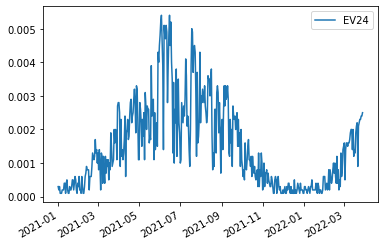

In [3]:
o = EvaporationObs.from_knmi(344)
display(o.head())
o.plot();

,RH
2021-01-01 01:00:00,0.0005
2021-01-02 01:00:00,0.0018
2021-01-03 01:00:00,0.0007
2021-01-04 01:00:00,0.0000
2021-01-05 01:00:00,0.0018


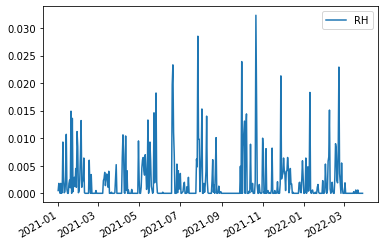

In [4]:
o = PrecipitationObs.from_knmi(344)
display(o.head())
o.plot();

**attributes**

A `MeteoObs` object has the following attributes:

* `name`: station name and variable
* `x`: x-coördinate in m RD
* `y`: y-coördinate in m RD
* `station`: station number
* `meta`: dictionary with other metadata

In [5]:
print(f"name: {o.name}")
print(f"x,y: {(o.x, o.y)}")
print(f"station: {o.station}")
print("metadata:")
for key, item in o.meta.items():
    print(f'    {key}: {item}')

name: RH_ROTTERDAM
x,y: (90598.0, 442813.0)
station: 344
metadata:
    LON_east: {'344': 4.447}
    LAT_north: {'344': 51.962}
    ALT_m: {'344': -4.3}
    NAME: {'344': 'Rotterdam'}
    RH: Etmaalsom van de neerslag (in m) (0 voor <0.05mm) / Daily precipitation amount (in m) (0 for <0.05mm)
    x: 90598.0
    y: 442813.0
    station: 344
    name: RH_ROTTERDAM


## Get KNMI data<a id=reading></a>

There are 2 main method to obtain meteorological data:

1. `from_knmi`
2. `from_nearest_xy`

Below you can see how they can be called to obtain the precipitation data. Notice that they return the same data because station 344 is nearest to the given xy coördinates.

In [6]:
o1 = PrecipitationObs.from_knmi(344)
o2 = PrecipitationObs.from_nearest_xy(90600, 442800)
o1.equals(o2)

True

**read options**

The `MeteoObs.from_knmi` method contains the following keyword arguments:

- `stn`: station number.
- `startdate`: the start date of the time series you want, default is 1st of January 2019.
- `enddate`: the end date of the time series you want, default is today.
- `fill_missing_obs`: option to fill missing values with values from the nearest KNMI station. If measurements are filled an extra column is added to the time series in which the station number is shown that was used to fill a particular missing value.
- `interval`: time interval of the time series, default is 'daily'
- `raise_exception`: option to raise an error when the requested time series is empty.
***

The 3 examples below give a brief summary of these options

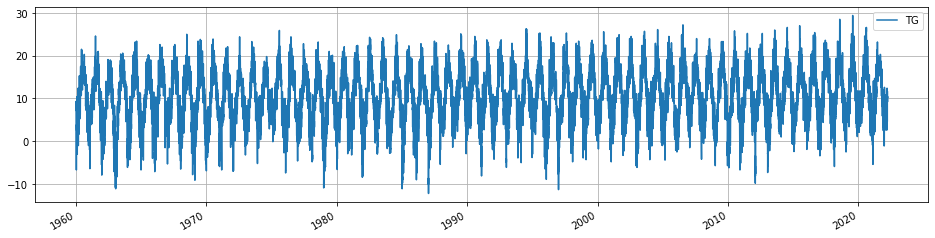

In [7]:
#example 1 get daily average temperature from 1900 till now
o_t = MeteoObs.from_knmi(344, 'TG', startdate='1960')
o_t.plot(figsize=(16,4), grid=True);

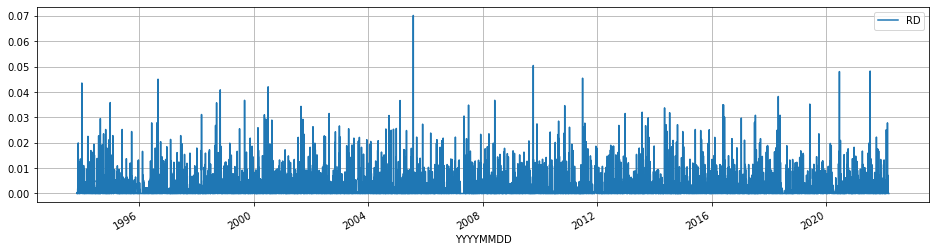

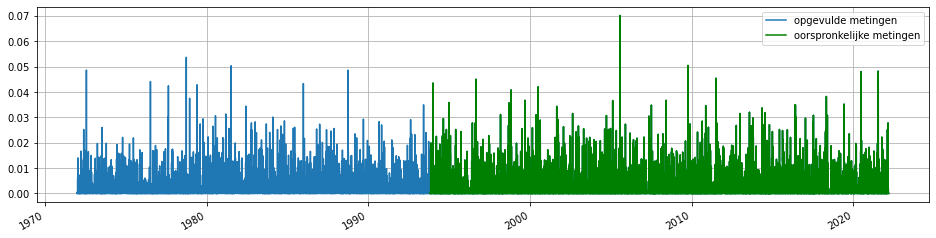

In [8]:
#example 2 get daily average precipitation from 1972 with and without filling missing measurements
o_rd = PrecipitationObs.from_knmi(892, stn_type='precipitation', startdate='1972', fill_missing_obs=False)
o_rd.plot(figsize=(16,4), grid=True)

o_rd_filled = PrecipitationObs.from_knmi(892, stn_type='precipitation', startdate='1972', fill_missing_obs=True)
fig, ax = plt.subplots()
o_rd_filled['RD'].plot(figsize=(16,4), ax=ax, label='opgevulde metingen');
o_rd_filled.loc[o_rd_filled['station_opvulwaarde'].isna(),'RD'].plot(color='green',ax=ax,grid=True,  label='oorspronkelijke metingen');
ax.legend();

In [9]:
#see the station_opvulwaarde
display(o_rd.head())
display(o_rd_filled.head())

,RD
YYYYMMDD,
1993-11-01 09:00:00,0.0000
1993-11-02 09:00:00,0.0000
1993-11-03 09:00:00,0.0005
1993-11-04 09:00:00,0.0000
1993-11-05 09:00:00,0.0000


,RD,station_opvulwaarde
1972-01-01 09:00:00,0.0000,910
1972-01-02 09:00:00,0.0000,910
1972-01-03 09:00:00,0.0000,910
1972-01-04 09:00:00,0.0000,910
1972-01-05 09:00:00,0.0004,910


In [10]:
# example 3 get evaporation and print additional information during download using the logging module
logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.INFO)

o_ev = EvaporationObs.from_knmi(344, startdate='1972', fill_missing_obs=True)
o_ev

INFO:hydropandas.io.io_knmi:download knmi EV24 data from station 344-ROTTERDAM between 1972-01-01 00:00:00 and 2022-03-28 14:23:30.996776
INFO:hydropandas.io.io_knmi:station 344 has no measurements before 1987-09-12 01:00:00
INFO:hydropandas.io.io_knmi:station 344 has 5809 missing measurements
INFO:hydropandas.io.io_knmi:trying to fill 5809 measurements with station [210]
INFO:hydropandas.io.io_knmi:download knmi EV24 data from station 210-VALKENBURG between 1972-01-01 00:00:00 and 2022-03-28 14:23:30.996776
INFO:hydropandas.io.io_knmi:trying to fill 5563 measurements with station [330]
INFO:hydropandas.io.io_knmi:download knmi EV24 data from station 330-HOEK-VAN-HOLLAND between 1972-01-01 00:00:00 and 2022-03-28 14:23:30.996776
INFO:hydropandas.io.io_knmi:trying to fill 5563 measurements with station [348]
INFO:hydropandas.io.io_knmi:download knmi EV24 data from station 348-CABAUW between 1972-01-01 00:00:00 and 2022-03-28 14:23:30.996776
INFO:hydropandas.io.io_knmi:trying to fill 549

,EV24,station_opvulwaarde
1972-01-01 01:00:00,0.0002,260
1972-01-02 01:00:00,0.0002,260
1972-01-03 01:00:00,0.0002,260
1972-01-04 01:00:00,0.0000,260
1972-01-05 01:00:00,0.0000,260
...,...,...
2022-03-24 01:00:00,0.0023,NaN
2022-03-25 01:00:00,0.0023,NaN
2022-03-26 01:00:00,0.0024,NaN
2022-03-27 01:00:00,0.0024,NaN


In [11]:
# reset the logging module
logging.getLogger().setLevel(logging.ERROR)

## Get ObsCollections<a id=readingOC></a>

It is also possible to read multiple `Observation` objects at once and store them in an `ObsCollection` object. For this we use the `ObsCollection.from_knmi()` method. Below an example to obtain precipitation (RH) and evaporation (EV24) from the KNMI station of Rotterdam and De Bilt. 

In [12]:
oc = ObsCollection.from_knmi(stns=[344, 260], meteo_vars=['RH', 'EV24'], ObsClass=[PrecipitationObs, EvaporationObs])
oc

,x,y,filename,station,meteo_var,obs
name,,,,,,
RH_ROTTERDAM,90598.000000,442813.000000,,344,RH,-----metadata------ name : RH_ROTTERDAM x : 9...
RH_DE-BILT,141002.996557,456772.017696,,260,RH,-----metadata------ name : RH_DE-BILT x : 141...
EV24_ROTTERDAM,90598.000000,442813.000000,,344,EV24,-----metadata------ name : EV24_ROTTERDAM x :...
EV24_DE-BILT,141002.996557,456772.017696,,260,EV24,-----metadata------ name : EV24_DE-BILT x : 1...


Besides giving a list of stations it is also possible to:
- specify `locations` as a dataframe with x, y coördinates (RD_new), the function will find the nearest KNMI station for every location.
- specify `xmid` and `ymid` which are 2 arrays corresponding to a structured grid to obtain the nearest KNMI station for every cell in the grid.

In [13]:
location = pd.DataFrame(index=['Rotterdam'], data ={'x':77500, 'y':399500})
ObsCollection.from_knmi(locations=location, 
                        meteo_vars=['RH'], ObsClass=[PrecipitationObs])

,x,y,filename,station,meteo_var,obs
name,,,,,,
RH_WOENSDRECHT,82881.403813,384958.510811,,340,RH,-----metadata------ name : RH_WOENSDRECHT x :...


In [14]:
ObsCollection.from_knmi(xmid=np.array([77500]), ymid=np.array([399500]), 
                        meteo_vars=['RH'], ObsClass=[PrecipitationObs])

,x,y,filename,station,meteo_var,obs
name,,,,,,
RH_WOENSDRECHT,82881.403813,384958.510811,,340,RH,-----metadata------ name : RH_WOENSDRECHT x :...


## Precipitation<a id=precipitation></a>

The KNMI database has three different precipitation products:
1. Daily data from a meteorological station
2. Daily data from a neerslag (precipitation) station
3. Hourly data from a meteorological station

All three products can be obtained using the `from_knmi` method. Product 1 and 2 can also be accessed without the api.

If you want to access the data from a neerslag (precipitation) station you should add `stn_type='precipitation'` to the `PrecipitationObs.from_knmi()` method. 

In [15]:
# daily meteo station
precip1 = PrecipitationObs.from_knmi(260, startdate='2010-1-1', enddate='2010-1-10', fill_missing_obs=False)

In [16]:
# daily neerslag station
precip2 = PrecipitationObs.from_knmi(550, stn_type='precipitation', startdate='2010-1-1', enddate='2010-1-10', fill_missing_obs=False)

In [17]:
# hourly meteo station (only works with api)
precip3 = PrecipitationObs.from_knmi(260, startdate='2010-1-1', enddate='2010-1-10', fill_missing_obs=False, interval='hourly')

In [18]:
# daily meteo station without api
precip4 = PrecipitationObs.from_knmi(260, startdate='2010-1-1', enddate='2010-1-10', fill_missing_obs=False, use_api=False)

In [19]:
# daily meteo station without api
precip5 = PrecipitationObs.from_knmi(550, stn_type='precipitation', startdate='2010-1-1', enddate='2010-1-10', fill_missing_obs=False, use_api=False)

Below are the differences between the precipitation estimates from different station types.

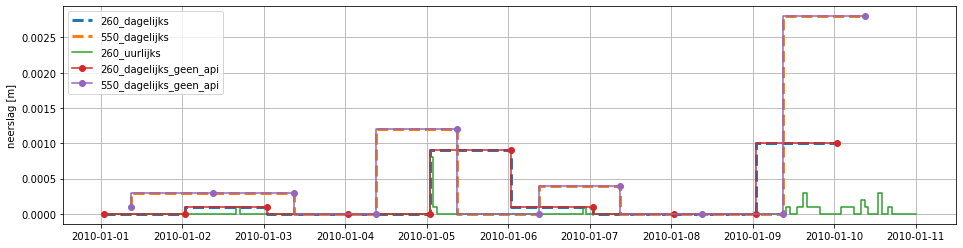

In [20]:
fig, ax = plt.subplots(figsize=(16,4))
ax.step(precip1.index, precip1.values, ls='--', lw=3, label=str(precip1.meta['station']) + '_dagelijks')
ax.step(precip2.index, precip2.values, ls='--', lw=3, label=str(precip2.meta['station']) + '_dagelijks')
ax.step(precip3.index, precip3.values, label=str(precip3.meta['station']) + '_uurlijks')
ax.step(precip4.index, precip4.values, marker='o', label=str(precip4.meta['station']) + '_dagelijks_geen_api')
ax.step(precip5.index, precip5.values, marker='o', label=str(precip5.meta['station']) + '_dagelijks_geen_api')
ax.legend()
ax.grid()
ax.set_ylabel('neerslag [m]');

The locations of the stations can be plotted onto a map, including the municipial borders.

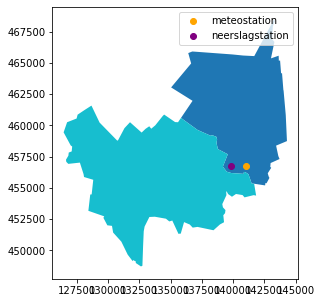

In [21]:
fig, ax = plt.subplots(figsize=(5,5))
# plot locaties meetstations
ax.plot(precip1.x, precip1.y, marker='o', color='orange', label='meteostation', ls="none")
ax.plot(precip2.x, precip2.y, marker='o', color='purple', label='neerslagstation', ls='none')

# voeg gemeentegrenzen toe
geodata_url = 'https://geodata.nationaalgeoregister.nl/cbsgebiedsindelingen/wfs?request=GetFeature&service=WFS&version=2.0.0&typeName=cbs_gemeente_2017_gegeneraliseerd&outputFormat=json'
gemeentegrenzen = gpd.read_file(geodata_url)
gemeentegrenzen.loc[gemeentegrenzen.statnaam.isin(['De Bilt', 'Utrecht'])].plot('statnaam',aspect=1, ax=ax, legend=True)
ax.legend();

## Types of Reference Evaporation<a id=EvapRef></a>

KNMI provides one type of reference evaporation, namely Makkink (variable EV24). Hydropandas provides a posssibility to calculate three different types of reference evaporation from data of KNMI meteo stations:
- Penman
- Hargreaves
- Makkink (in the same way as KNMI)

These three types of reference evaporation are calculated the same way as described by [Allen et al. 1990](https://www.fao.org/3/x0490E/x0490e07.htm#solar%20radiation) and [STOWA rapport](https://edepot.wur.nl/163482). Beware that the last report is written in Dutch and contains errors in the units.

The following variables from the KNMI are used for each reference evaporation type:
- Makkink: average temperature (TG) and global radiation (Q)
- Penman: average (TG), minimum (TN) and maximum (TX) temperature, de global radiation (Q), de windspeed (FG) en de relative humidity (PG).
- Hargreaves: average (TG), minimum (TN) and maximum (TX) temperature

In [22]:
ev24 = EvaporationObs.from_knmi(260).squeeze() # et_type='EV24' by default
makk = EvaporationObs.from_knmi(260, et_type='makkink').squeeze()

### Comparison Makkink

Lets compare Hypdropandas Makkink verdamping evaporation with the EV24 Makkink verdamping of the KNMI. When Hydropandas Makkink evaporation is rounded (on 4 decimals), the estimate is the same as for the KNMI estimate.

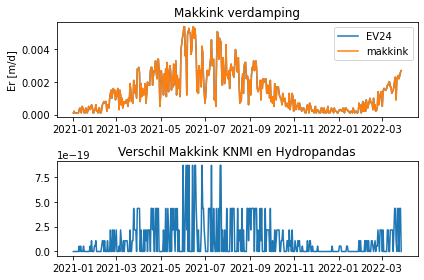

In [23]:
f, ax = plt.subplots(2, figsize=(6,4))
ax[0].plot(ev24, label=ev24.name)
ax[0].plot(makk.round(4), label=makk.name)
ax[0].set_ylabel('Er [m/d]')
ax[0].set_title('Makkink verdamping')
ax[0].legend()
ax[1].plot(ev24-makk.round(4))
ax[1].set_title('Verschil Makkink KNMI en Hydropandas')
f.tight_layout()

In [24]:
penm = EvaporationObs.from_knmi(260, et_type='penman').squeeze()
harg = EvaporationObs.from_knmi(260, et_type='hargreaves').squeeze()

### Comparison Penman, Makkink en Hargreaves
On average Penman gives a higher estimate for reference evaporation than Makkink (~0.55mm). This can be explained by the fact that Penman takes into account windspeed and Makkink ignores this proces. Hargreaves is a very simple way of estimation the evaporation, only taking into account temperature and extraterrestial radiation. Therefore it gives a lower estimate for the reference evporatoin compared to the two other methods (~-0.35mm wrt Makkink).

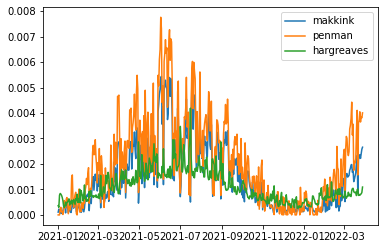

In [25]:
f, ax = plt.subplots(figsize=(6,4))
ax.plot(makk, label=makk.name)
ax.plot(penm, label=penm.name)
ax.plot(harg, label=harg.name)
ax.legend();